The Newton-Raphson method usually requires a 'good' initial guess in order to converge to a solution, so to generate solutions corresponding to strongly deformed channels a continuation technique should be used. (The shooting method can also benefit from this approach, but it is not usually necessary.) We start the computation with parameter values corresponding to a known solution (e.g., a slightly deformed channel with $P_d = 0$, $Q \ll 1$) and use the undeformed channel ($H = 1$) as an initial guess. Having found this solution, we can then slowly increment the parameters $Q$ and $P_d$ to construct solutions with the channel highly deformed.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import brentq

def solve_fd_robust(Q, Pd, N=101, use_continuation=True):
    dx = 1.0 / (N - 1)
    x = np.linspace(0, 1, N)

    # Internal solver step
    def solve_step(q_val, pd_val, h_guess):
        H = h_guess.copy()
        damping = 0.5

        for iter_idx in range(50):
            J = np.zeros((N, N))
            F = np.zeros(N)

            # Row 0: Upstream BC: H(0) = 1
            F[0] = H[0] - 1.0
            J[0, 0] = 1.0

            # Row 1: Downstream Pressure BC: H''(L) = -Pd
            coeff_pres = np.array([-1, 4, -5, 2]) / dx**2
            idxs_p = [N-4, N-3, N-2, N-1]
            H_xx = np.dot(coeff_pres, H[idxs_p])
            F[1] = H_xx + pd_val
            for k, node in enumerate(idxs_p):
                J[1, node] = coeff_pres[k]

            # Rows 2 to N-3: Interior ODE (Central)
            coeff_cen = np.array([-1, 2, 0, -2, 1]) / (2 * dx**3)

            for i in range(2, N-2):
                idxs = [i-2, i-1, i, i+1, i+2]
                H_loc = H[idxs]
                H_xxx = np.dot(coeff_cen, H_loc)

                # Residual
                F[i] = H_xxx * (H[i]**3) - q_val

                # Jacobian
                for k, node in enumerate(idxs):
                    term = coeff_cen[k] * (H[i]**3)
                    if node == i:
                        term += H_xxx * 3 * (H[i]**2)
                    J[i, node] = term

            # Row N-2: Near-Boundary ODE (Backward)
            i = N-2
            coeff_back = np.array([1, -6, 12, -10, 3]) / (2 * dx**3)
            idxs = [i-3, i-2, i-1, i, i+1]
            H_loc = H[idxs]
            H_xxx = np.dot(coeff_back, H_loc)
            F[i] = H_xxx * (H[i]**3) - q_val
            for k, node in enumerate(idxs):
                term = coeff_back[k] * (H[i]**3)
                if node == i:
                    term += H_xxx * 3 * (H[i]**2)
                J[i, node] = term

            # Row N-1: Downstream BC H(L) = 1
            F[N-1] = H[N-1] - 1.0
            J[N-1, N-1] = 1.0

            # Check Convergence
            if np.linalg.norm(F, np.inf) < 1e-6:
                return True, H

            # Solve
            try:
                # np.linalg.solve is robust against pivoting issues
                delta = np.linalg.solve(J, -F)
                H_new = H + damping * delta

                # Clamp to prevent breaking
                H_new[H_new < 0.05] = 0.05
                H_new[H_new > 10.0] = 10.0
                H = H_new
            except np.linalg.LinAlgError:
                return False, H

        return False, H

    current_H = np.ones(N)

    if use_continuation and Q != 0:
        # Ramp Q (at Pd=0)
        qs = np.linspace(0, Q, 10)
        for q_s in qs:
            success, res_H = solve_step(q_s, 0, current_H)
            if success: current_H = res_H

        # Ramp Pd (at Q=Target)
        pds = np.linspace(0, Pd, 10)
        for p_s in pds:
            success, res_H = solve_step(Q, p_s, current_H)
            if success: current_H = res_H

        success, current_H = solve_step(Q, Pd, current_H)
    else:
        success, current_H = solve_step(Q, Pd, current_H)

    # Pressure
    P = np.zeros_like(x)
    for i in range(1, N-1):
        P[i] = -(current_H[i-1] - 2*current_H[i] + current_H[i+1]) / (dx**2)
    P[0] = 2*P[1] - P[2]; P[-1] = Pd

    return x, current_H, P

def solve_shooting_robust(Q, Pd):
    def tube_ode(t, y):
        H, Hp, Hpp = y
        denom = H**3 if H > 1e-4 else 1e-4
        return [Hp, Hpp, Q/denom]

    def get_residual(beta):
        try:
            sol = solve_ivp(tube_ode, [1, 0], [1, beta, -Pd], method='Radau', rtol=1e-6, atol=1e-6)
            return sol.y[0][-1] - 1.0
        except: return 1e5

    # Scan for bracket
    betas = np.linspace(-50, 50, 100)
    bracket = None
    vals = [get_residual(b) for b in betas]
    for i in range(len(vals)-1):
        if vals[i] * vals[i+1] < 0:
            bracket = [betas[i], betas[i+1]]
            break

    x_sh, h_sh, p_sh = [], [], []
    if bracket:
        try:
            beta_opt = brentq(get_residual, bracket[0], bracket[1])
            sol = solve_ivp(tube_ode, [1, 0], [1, beta_opt, -Pd], method='RK45', dense_output=True)
            x_sh = np.linspace(0, 1, 101)
            h_sh = sol.sol(x_sh)[0]
            p_sh = -y[2]
        except: pass
    return x_sh, h_sh, p_sh

def analytical_static(x, Pd):
    return 1.0 + (Pd / 2.0) * x * (1.0 - x)

When $Q=0$, the fluid is static, so the pressure gradient is zero $P_x = 0$. Thus, pressure is constant throughout the channel $P(x) = P_d$. The governing equation becomes
\begin{equation}
    H_{xx} = -P_d .
\end{equation}
Integrating twice with boundary conditions $H(0)=1$ and $H(1)=1$ yields
\begin{equation}
    H(X) = 1 + \frac{P_d}{2}X(1-X).
\end{equation}
This describes a symmetric parabola. If $P_d > 0$, then the channel bows out $H > 1$. If $P_d < 0$, then it bows in $H < 1$.

For small deformations $|H-1| \ll 1$ and  $Q > 0$, let $H \approx 1$. The governing ODE $H_{xxx} = Q/H^3$ approximates to
\begin{equation}
    H_{xxx} \approx Q.
\end{equation}
Integrating three times and using boundary conditions $H(0)=1$, $H(1)=1$ and $P(1) = -H''(1) = P_d$, we find the following cubic profile
\begin{equation}
    H(X) \approx 1 + \frac{Q}{6}(X^3 - X) + \frac{P_d + Q}{2}(X - X^2).
\end{equation}
Depending on the balance between flux $Q$ and pressure $P_d$, this cubic function allows for three regimes:
1.  Dilated: Pressure dominates outward.
2.  Collapsed: Pressure dominates inward.
3.  Mixed: The $X^3$ term (driven by flux) creates asymmetry, allowing the upstream to be dilated while the downstream collapses.

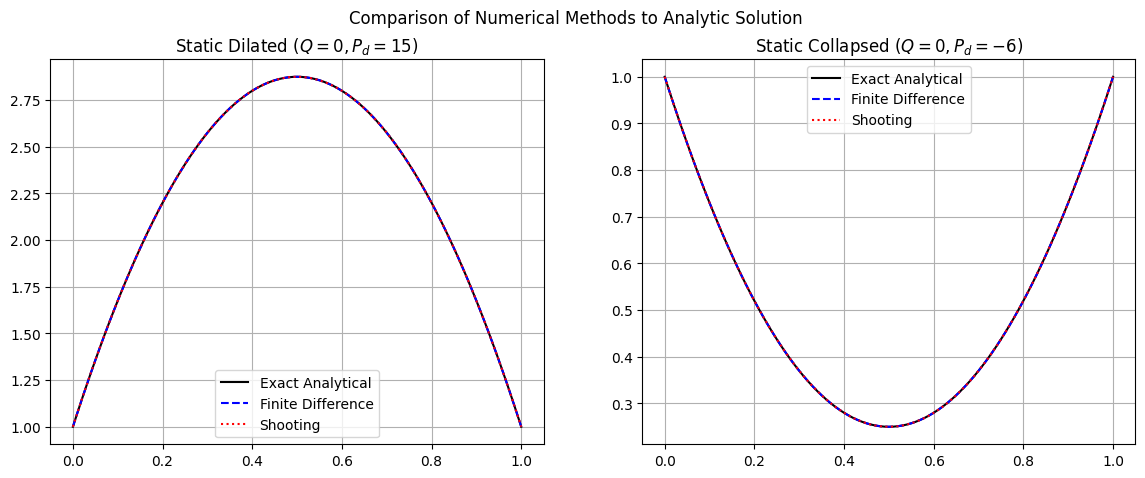

In [11]:
fig1, axs1 = plt.subplots(1, 2, figsize=(14, 5))

Pd_pos = 15
x_fd, H_fd_pos, _ = solve_fd_robust(0, Pd_pos, use_continuation=False)
x_sh, H_sh_pos, _ = solve_shooting_robust(0, Pd_pos)
x_an = np.linspace(0, 1, 101)
H_an_pos = analytical_static(x_an, Pd_pos)
axs1[0].plot(x_an, H_an_pos, 'k-', label='Exact Analytical')
axs1[0].plot(x_fd, H_fd_pos, 'b--', label='Finite Difference')
axs1[0].plot(x_sh, H_sh_pos, 'r:', label='Shooting')
axs1[0].set_title(f'Static Dilated ($Q=0, P_d={Pd_pos}$)')
axs1[0].grid(True)
axs1[0].legend()

Pd_neg = -6
x_fd, H_fd_neg, _ = solve_fd_robust(0, Pd_neg, use_continuation=False)
x_sh, H_sh_neg, _ = solve_shooting_robust(0, Pd_neg)
H_an_neg = analytical_static(x_an, Pd_neg)
axs1[1].plot(x_an, H_an_neg, 'k-', label='Exact Analytical')
axs1[1].plot(x_fd, H_fd_neg, 'b--', label='Finite Difference')
axs1[1].plot(x_sh, H_sh_neg, 'r:', label='Shooting')
axs1[1].set_title(f'Static Collapsed ($Q=0, P_d={Pd_neg}$)')
axs1[1].grid(True)
axs1[1].legend()

plt.suptitle("Comparison of Numerical Methods to Analytic Solution")
plt.show()

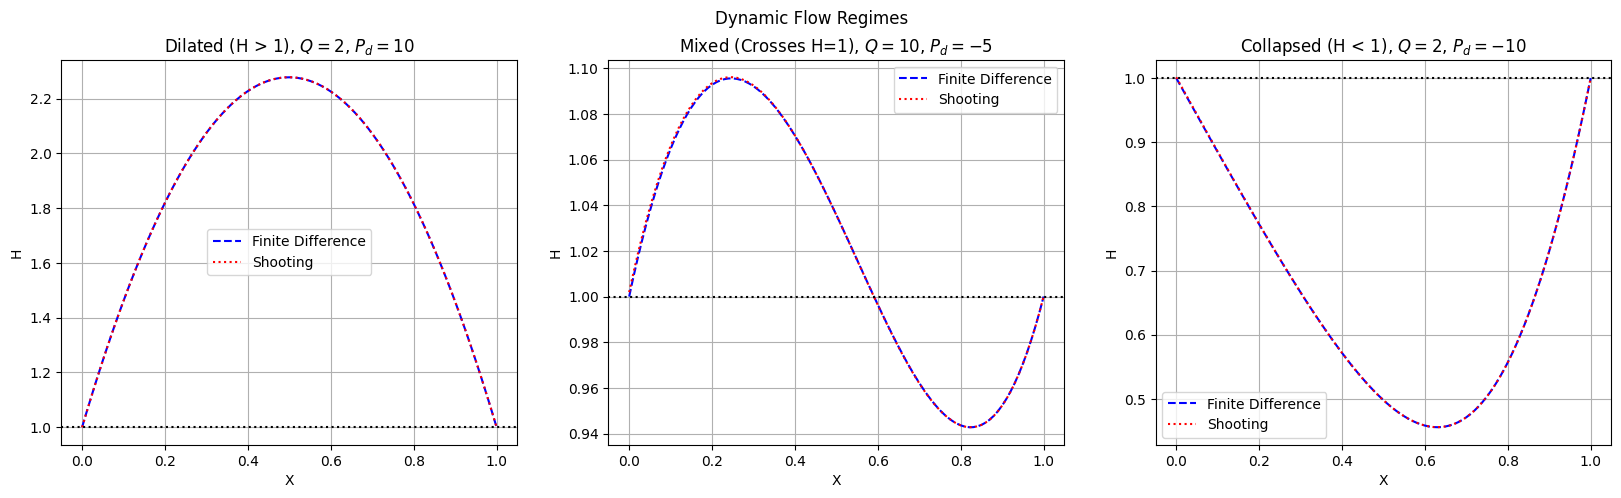

In [27]:
regimes = [
    (2, 10, "Dilated (H > 1)"),
    (10, -5, "Mixed (Crosses H=1)"),
    (2, -10, "Collapsed (H < 1)")
]

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(f'Dynamic Flow Regimes')

for i, (Q_val, Pd_val, label) in enumerate(regimes):
    x_fd, H_fd, _ = solve_fd_robust(Q_val, Pd_val, use_continuation=True)
    x_sh, H_sh, _ = solve_shooting_robust(Q_val, Pd_val)
    axs[i].plot(x_fd, H_fd, 'b--', label='Finite Difference')
    axs[i].plot(x_sh, H_sh, 'r:', label='Shooting')
    axs[i].axhline(1.0, color='k', linestyle=':')
    axs[i].set_title(f'{label}, $Q = {Q_val}$, $P_d={Pd_val}$')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('H')
    axs[i].grid(True)
    axs[i].legend()

plt.show()

In the static regime $Q=0$, the channel shape is a perfectly symmetric parabola about $X=1/2$ as the pressure is constant throughout the channel. Here, the channel is either entirely dilated $H > 1$ or entirely collapsed $H < 1$, determined solely by the sign of $P_d$.

In constrast, within the dynamic regime $Q>0$, the flow induces a pressure gradient $P_u > P_d$ to overcome viscous forces. This breaks the symmetry. The channel is generally wider upstream (where pressure is higher) and narrower downstream. Here, a mixed state is possible where the channel starts dilated due to high upstream pressure driving the flow, but collapses downstream as pressure falls below zero.

This is physically significant as it models phenomena like flow limitation in airways, where the airway remains open near the lungs but may collapse near the mouth/throat during forced expiration.